# Rasmus og Lasse - Walmart 1/2

# 
We have been asked by Walmart to precisely forecast certain products 28 days in advance for 3 different stores across America. The 3 stores are located in Texas, California and Wisconsin. They all have the same departments, where they sell different items.

For this competition we will measure our models accuracy from the metric is Weighted Root Mean Squared Scaled Error (WRMSSE)


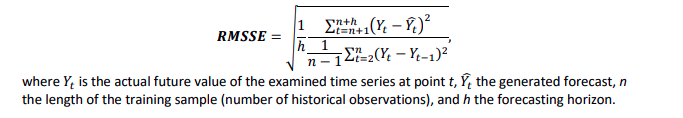

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
import gc
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima_model import ARMA 
import seaborn as sns
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

In [ ]:
calendar = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
train_sales = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
sample_submission = pd.read_csv('../input/m5-forecasting-accuracy/sample_submission.csv')
sell_prices = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')

In the EDA we want to explore our datasets, and see what kind of data, we are dealing with. 

In [ ]:
calendar.head()

The calendar set, has date infos about how many snaps (foodstamps) have been used in each store. It also has an id columns to the train_sales set.

In [ ]:
train_sales.head()

 We are dealing with a sales_training set where the sales for different items are represented. Here we can also see how much a certain item sold on each day.

In [ ]:
sell_prices.head()

In the sell_prices set, we can see the different prices each individual item is sold at over time. 

In [ ]:
sample_submission.head()

In [ ]:
sample_submission.tail()

This file contains the collected info on each different item from each store. The submission file is a bit different from other submission files. It both have a validation area in the first part, and an evaluation in the last part. We cannot use the evalutation part now, because it is not released. 

# Visualization

Here we wanted to see, how the different categories sold across one store.

In [ ]:
wi3_sales = train_sales.loc[train_sales['store_id'] == 'WI_3']

In [ ]:
plt.figure(figsize=(12, 4))
for d in wi3_sales['dept_id'].unique():
    store_sales = wi3_sales.loc[wi3_sales['dept_id'] == d]
    store_sales.iloc[:, 6:].sum().rolling(30).mean().plot(label=d)
plt.title('WI_3 sales by category, rolling mean 30 days')
plt.legend(loc=(1.0, 0.5));

We can clearly see, that FOODS_3 sold much more than all the other categories. We can also see that the data is very stationary and follows a certain trend which does not deviate much from the mean.

Now we wanted to look at the sell prices across departmens and see if that has any affect on the data.

In [ ]:
wi_3_prices = sell_prices.loc[sell_prices['store_id'] == 'WI_3']
wi_3_prices['dept_id'] = wi_3_prices['item_id'].apply(lambda x: x[:-4])

In [ ]:
wi_3_prices

In [ ]:
plt.figure(figsize=(12, 6))
for d in wi_3_prices['dept_id'].unique():
    small_df = wi_3_prices.loc[wi_3_prices['dept_id'] == d]
    grouped = small_df.groupby(['wm_yr_wk'])['sell_price'].mean()
    plt.plot(grouped.index, grouped.values, label=d)
plt.legend(loc=(1.0, 0.5))
plt.title('WI_3 mean sell prices by dept');

Here we can see that the sales prices are very steady, and almost all of the sales prices stay the same, exept for HOBBIES_1 which has a huge jump in the mean price per item.

It looks like that there is an anomaly in the HOBBIES_1 columns, and this migth cause the data to be tainted from before that date. 

# Total sale visualization

We here want to have some data visualization from the different categories across stores. We therefore need to concatinate the train_sales and calendar dataset.

In [ ]:

train_sales_dept = train_sales.groupby(['dept_id']).sum() #group sales by department
train_sales_item = train_sales.groupby(['item_id']).sum() #group sales by item_id
train_sales_cat = train_sales.groupby(['cat_id']).sum().T #group sales by category
train_sales_cat['day'] = train_sales_cat.index

train_sales_store = train_sales.groupby(['store_id']).sum()
train_sales_state_id = train_sales.groupby(['state_id']).sum()

data_calendar = calendar.iloc[:, [0,2,3,4,5,6,7]]

#Merge data_calendar columns related to days of the week, month and year.
train_sales_cat = pd.merge(data_calendar, train_sales_cat, how = 'inner', left_on='d', right_on='day')
train_sales_cat_final = train_sales_cat.iloc[:,[7,8,9]]
train_sales_cat_final.index = train_sales_cat['date']
train_sales_cat_final.index = pd.to_datetime(train_sales_cat_final.index)
train_sales_cat_final.parse_dates =train_sales_cat_final.index


In [ ]:
train_sales_cat_final.head(10)

In [ ]:
train_sales_cat_final.plot()

Here we see, how much is sold in each category for each day in the dataset. 

We can also see that each year, there is a huge drop in sales at the end of the year. This indicates, that Walmart is closed on Christmas, and that could be something, the model, maybe should account for. 

We can also see a moderate correlation between the three categories. (This is explored further below)

In [ ]:
sns.heatmap(train_sales_cat_final[['FOODS','HOBBIES','HOUSEHOLD']].corr(), annot = True,  cbar=True)

Here we can see the correlation between the categories. 

It seems there is a pretty high correlation (0.82) between the FOODS and the HOUSEHOLD items.
There is also high correlation between HOBBIES and HOUSEHOLD items, but this is not an indicator for that there is a causation.

The only one there is low correlation is between FOODS and HOBBIES. 

# Time series forecasting

In [ ]:
train_sales_cat_final_monthly = train_sales_cat_final.iloc[:,[0,1,2]].resample('M').sum()[2:-1] 

In [ ]:
train_sales_cat_final_monthly.plot()

Here we wanted to get a single line in the time period, to clearly see if the data was stationary, and we can conclude it is not.  

In [ ]:
plot_acf(train_sales_cat_final_monthly.FOODS, lags=12)

Here we are using autocorrelation plot to see, if the lags of the time series in a 12 lag period have an affect on later sales. 
We can therefore see, that the lags inside the blue area is not statistically significant and based on the decay in the lags (because they are slowly decaying).

In [ ]:
plot_pacf(train_sales_cat_final_monthly.FOODS, lags=12)

From our analysis of the pacf plot, we can that it is only the first lag that is statistically significant.

Now that we are working with a time series dataset(s), it would be a good idea to test if it is stationary or not.

In [ ]:
result = adfuller(train_sales_cat_final['FOODS'])
print(result)

We are in this example just testing the FOODS category.

The significant thing to look at here is the second value. That is the p-value, that is used to either reject or accept the null hypothesis. We accept the null hypothesis, because the value is greater than 5% (0.05) and the dataset is therefore non-stationary. 

In [ ]:
train_sales_cat_final['FOODS'].plot()

We can clearly see, that there is an upward mean, and it is therefore it is not stationary. It also have some seasonality, because it drops each year around christmas. 

# ARMA model

In our analysis we could conclude that our datasets is non-stationary, so we need to make stationary but we did not succeed with that, so we will just show you the theory behind how you can use an ARMA model. 

In [ ]:
model = ARMA(train_sales_cat_final['FOODS'], order=(1,3))
result = model.fit()

Here we are giving our ARMA model the parameters 1 and 3. These values comes from the ACF and PACF plots. The 1 comes from the PACF, which shows 1 statistics significant lag and the 3 comes from the ACF which shows 3 statistics significant lags.

In [ ]:
predict = result.predict()
predict.plot()

In [ ]:
result.summary()

* Method - css-mile : The type of calculation that was used for defining the parameters (conditional sum of squares)
* Log Likelihood : Measures the maximum likelihood estimation. Used mostly for comparing models. The higher the score the better
* AIC (Akaike’s Information Criterion) : Shows the strength of your model. The lower the AIC the better the model.
* BIC (Bayesian Information Criterion) : Like AIC can help you determine the strength of your model. The lower the BIC the better is the model. 
* coef : Represents the significance of the features in the dataset. (The higher the better)
* std err : Shows how much your residual is from your predicted value. It tells you how far your model was from predicting correctly
* z : It is the values of ‘coef’ divided by ‘std err’. It is therefore the standardised coefficient